# CSCI E-118 Final Project
## Blockchain Fraud Prediction using Machine Learning
### Kartik Srikumar

## Introduction
The main idea of this project is to predict cases of blockchain fraud by leveraging machine learning. Specifically, I am using a dataset with multiple features such as value details of transactions sent by an address, time between transactions etc., along with the label (or target) ‘FLAG’ which will have
binary values; 1 indicating an instance of Fraud and 0 indicating the absence thereof. I plan to use a Supervised Learning approach, comparing multiple
classification models and selecting one or more of them, based on the trade-off between recall score and False Positive prediction.

## Importing Libraries
All the libraries used in this project are imported in the following cell for cleanliness. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

## Exploratoty Data Analysis
Bulding a DatFrame from the data which is in .csv format. The source of the data is Kaggle (https://www.kaggle.com/vagifa/ethereum-frauddetection-dataset).

In [2]:
df = pd.read_csv ('transaction_dataset.csv')

Exploring the data by looking at its dimensions, its first 5 rows as well as some basic statistics including meadures of central tendency.

In [3]:
df.shape #number of rows and columns

(9841, 51)

In [4]:
df.head() #first 5 rows

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.00,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.00,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.05,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.00,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.00,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421896,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [5]:
df.describe() #view some measures of central tendency (mean etc.)

,Unnamed: 0,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9.841000e+03,9.841000e+03,9841.000000,9.841000e+03,9012.000000,9.012000e+03,9.012000e+03,9012.000000,9012.000000,9012.000000,9012.000000,9012.000000,9012.0,9012.0,9012.0,9012.0,9012.000000,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,4920.000000,1815.049893,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,523.152481,100.711721,4.800090,314.617297,44.755731,0.000003,0.000008,0.000005,283.362362,1.016092e+04,1.163832e+04,0.000008,1.477395e+03,36.255659,1.296207e+08,1.386849e+07,110.939207,5.638038,7.598535,0.003440,4.901909,0.0,0.0,0.0,0.0,485.614688,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,2840.996333,1222.621830,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,13008.821539,2885.002236,138.609682,6629.212643,239.080215,0.000225,0.000516,0.000323,1352.404013,3.583227e+05,3.642048e+05,0.000516,2.424254e+05,447.528908,1.053858e+10,1.180390e+09,6128.634953,105.252500,81.818470,0.065698,17.246576,0.0,0.0,0.0,0.0,16883.278712,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.560535e+07,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,2460.000000,821.000000,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,1.000000,0.426905,0.000000,0.164577,0.086184,0.000000,0.000000,0.000000,4.000000,2.262059e-01,2.670424e+00,0.000000,6.214900e-04,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,4920.000000,1641.000000,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,6.000000,1.729730,0.049126,4.999380,1.606000,0.000000,0.000000,0.000000,8.000000,1.248680e+01,3.052963e+01,0.000000,1.722000e-03,1.000000,1.000000e-12,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,7

In this dataset, we see that the columns 'ERC20 uniq rec contract addr', 'ERC20 avg time between sent tnx', 'ERC20 avg time between rec tnx', 'ERC20 avg time between rec 2 tnx', 'ERC20 avg time between contract tnx', 'ERC20 min val sent contract', 'ERC20 max val sent contract', 'ERC20 avg val sent contract', seem to have no values apart from 0, so removing them:

In [6]:
df = df.drop(columns =[' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']) #removing columns which do add value

Understanding the schema of the dataset.

In [7]:
df.info() #understanding dataset schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 44 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

Three columns: Address, ERC20 most sent token type and ERC20_most_rec_token_type, are of type 'object', which cannot be used in the modeling functions used ahead. Removing them:

In [8]:
df = df.select_dtypes(exclude=['object'])

Additionally, the columns: 'Unnamed: 0' and 'Index', provide an index which is not of value to the modeling. Removing them:

In [9]:
df = df.drop(columns =['Unnamed: 0', 'Index'])

As stated earlier, the Fraud instances are indicated by the column 'FLAG' which has binary values. Understanding the balance of the label is important.

In [10]:
df['FLAG'].value_counts() #checking the label balance

0    7662
1    2179
Name: FLAG, dtype: int64

While there are many theories around what must be done with imbalanced labels in data, I will be following the simple approach of leaving as is since there seems to be a decent proportion of the FLAG = 1, with 22.14% of the data being 'flagged' as fraud. If the proportion was lower, we could use various techniques such as minority oversampling using SMOTE etc.

Droppping rows with NAN values.

In [11]:
df = df.dropna()

Plotting the correlation between features of the dataset. This allows to better understand if any features are very strongly correlated with each other.

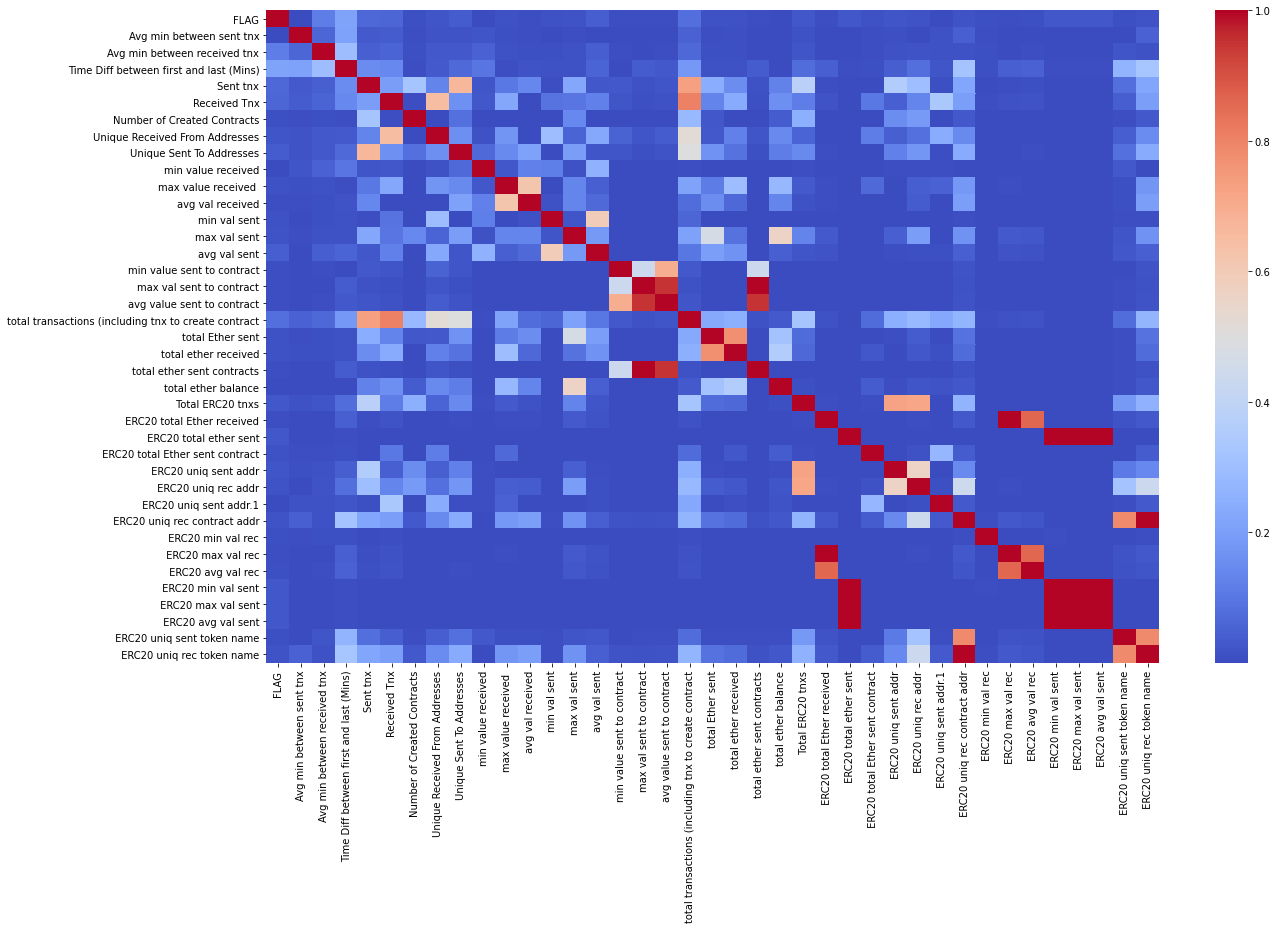

In [12]:
corr = df.corr()
plt.figure(figsize=(20,12))
sn.heatmap(np.abs(corr), cmap='coolwarm')
plt.show()

Looking at the areas in the correlation matrix where 2 features are highly correlated (depicted by peach/orange color), we do not see any surprises. For example average value received is highly correlated with total ether received, which is expected.



Building the Feature set as well as the Labels. Using conventions of 'X' and 'y'

In [13]:
X = df.drop('FLAG',axis = 1)
y = df.FLAG

Splitting the data into a training set which will be used to train the model(s) as well as a test set, which will be unseen by the model and therefore can be used to test is prediction capabilities. Using a 70-30 split.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4) #random_state allows for the RNG to be deterministic for reproduction and testing 

## Feature Selection
Using 2 statistical techniques to reduce feature set to include those which have a higher importance in determining the target variable : Chi Square as well as ANOVA F-value. Additionally using the SelectKBeat function to pick the top features after applying the techniques mentioned above. 

In [15]:
X = df.drop('total ether balance', axis = 1) #Chi square requires non-negative values, therefore dropping 'total ether balance'

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4) #random_state allows for the RNG to be deterministic for reproduction and testing 

#### Chi Square:

In [17]:
X_chi_best= SelectKBest(chi2, k=35).fit(X_train, y_train)
mask = X_chi_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, X_train.columns):
 if bool:
  new_feat.append(feature)

X = df[new_feat]
X = df.drop('FLAG',axis = 1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4) #random_state allows for the RNG to be deterministic for reproduction and testing 

#### ANOVA F-value:

In [19]:
X_f_best= SelectKBest(f_classif, k=32).fit(X_train, y_train)
mask = X_f_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, X_train.columns):
 if bool:
  new_feat.append(feature)

X = df[new_feat]
X = df.drop('FLAG',axis = 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4) #random_state allows for the RNG to be deterministic for reproduction and testing 

## Decision Tree Classifier
The first model being explored is the Decision Tree, more specifically a binary Decision Tree model, which creates a tree behind the scenes based on the features and then makes predictions based on traversal through the tree. Using the sklearn function to invoke the model.

In [21]:
dt = DecisionTreeClassifier() #Decision Tree classifer object
dt = dt.fit(X_train,y_train) #Train by fitting to training set
y_pred = dt.predict(X_test) #Predict fraud/label/'FLAG' on the test set

Evaluating the model. First we will calculate Accuracy, which is defined as the proportion of the predictions in the test set were correct.


In [22]:
dt_acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",dt_acc)

Accuracy: 0.9630177514792899


The issue with usinf accuracy to evaluate model performance is that, given the imbalance of the data, even a random guess of all items being 'Not fraud' would yield a high accuracy. Therefore, we are better off using recall, which is defined as the proportion of the fraud predicted correctly. Mathematically:

$ Recall = \frac {True Positives} {True Positives + False Negatives} $

In [23]:
dt_rec = metrics.recall_score(y_test, y_pred)
print("Recall:",dt_rec)

Recall: 0.9132530120481928


### Tuning the Decision Tree
The Decision Tree Classifier has a parameter called max_depth which essentially caps the maximum depth of the tree. We will use various values for max_depth to attempt to increase our recall score. In order to do this, I have created a quick ***helper function*** rather than using the out of the box paramGrid and CrossValidator functions from scikit learn, since I want to customize the tuning to my specific needs. This function is built so it can be used in later models as well.

#### Helper Function for Tuning Models

In [24]:
Keymax=0
dt_rec=0
dt_fp=0
lr_rec=0
lr_fp=0
rf_rec=0
rf_fp=0
gbt_rec=0
gbt_fp=0

def tuner(model, lo=0, hi=100): # The 'tumer' function takes in 3 parameters, 2 of which are optional
  
  paramDict = {}
  global Keymax
  global dt_rec
  global rf_rec
  global gbt_rec
  global dt_fp
  global lr_fp
  global rf_fp
  global gbt_fp
  global y_pred
  global y_test

  def perf_measure(y_test, y_pred): #the perf_measure function is used to calculate false positives (source: https://datascience.stackexchange.com/questions/28493/confusion-matrix-get-items-fp-fn-tp-tn-python)
    FP = 0
    y_test_array = y_test.to_list()
    for i in range(len(y_pred)): 
        if y_pred[i] == 1.0 and y_test_array[i] != y_pred[i]:
           FP += 1
    return(FP)

  if model == 'dt':
    while lo <= hi:
      m = DecisionTreeClassifier(max_depth=lo)
      m = m.fit(X_train,y_train)
      y_pred = m.predict(X_test)
      rec = metrics.recall_score(y_test, y_pred)
      paramDict.update({lo: rec})
      lo += 1
    Keymax = max(paramDict, key=paramDict.get) # Keymax stores the value of the parameter that yielded the best recall score
    dt_rec = paramDict[Keymax]
    dt_fp = perf_measure(y_test, y_pred)
    return Keymax, dt_rec, dt_fp

  elif model == 'lr':
    lrParams = ["l2", "none"]
    for param in lrParams:
      m = LogisticRegression(max_iter=100000, penalty=param)
      m = lr.fit(X_train,y_train) 
      y_pred = m.predict(X_test) 
      rec = metrics.recall_score(y_test, y_pred)
      paramDict.update({param: rec})
    Keymax = max(paramDict, key=paramDict.get) 
    lr_rec = paramDict[Keymax]
    lr_fp = perf_measure(y_test, y_pred)
    return Keymax, lr_rec, lr_fp  
    
  elif model == 'rf':
    while lo <= hi:
      m = RandomForestClassifier(n_estimators=lo)
      m = m.fit(X_train,y_train)
      y_pred = m.predict(X_test) 
      rec = metrics.recall_score(y_test, y_pred)
      paramDict.update({lo: rec})
      lo += 1
    Keymax = max(paramDict, key=paramDict.get)
    rf_rec = paramDict[Keymax]
    rf_fp = perf_measure(y_test, y_pred)
    return Keymax, rf_rec, rf_fp


  elif model == 'gbt':
    while lo <= hi:
      m = GradientBoostingClassifier(n_estimators=lo)
      m = m.fit(X_train,y_train)
      y_pred = m.predict(X_test)
      rec = metrics.recall_score(y_test, y_pred)
      paramDict.update({lo: rec})
      lo += 1
    Keymax = max(paramDict, key=paramDict.get)
    gbt_rec = paramDict[Keymax]
    gbt_fp = perf_measure(y_test, y_pred)
    return Keymax, gbt_rec, gbt_fp
 


Using the tuner to get the best possible parameter value as well as corresponding recall score.

In [25]:
tuner('dt', 5, 100)

(89, 0.927710843373494, 65)

We did improve the recall! Our tuning was successful! 

Creating a Confusion Matrix and visualizing it to understand the True Negatives,False Negatives, True Positives and False Positives.

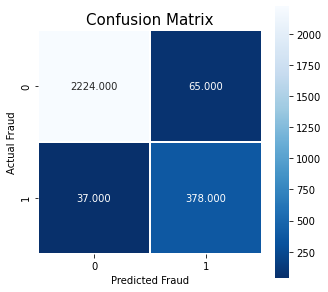

In [26]:
dt_cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sn.heatmap(dt_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Fraud');
plt.xlabel('Predicted Fraud');
all_sample_title = 'Confusion Matrix'
plt.title(all_sample_title, size = 15);

## Logistic Regression
The next model being explored is the logistic regression model, more specifically a binary logistic regression model, which models the probability of a binary class. Again, using the sklearn function to invoke the model.

The flow of code is similar to that of the Decision Tree.

In [27]:
lr = LogisticRegression(max_iter=100000) #Logistic Regression classifer object
lr = lr.fit(X_train,y_train) #Train by fitting to training set
y_pred = lr.predict(X_test) #Predict fraud/label/'FLAG' on the test set

In [28]:
lr_rec = metrics.recall_score(y_test, y_pred)
print("Recall:",lr_rec)

Recall: 0.004819277108433735


In [29]:
tuner('lr')

('l2', 0.004819277108433735, 2)

Since the Logistic Regression model has a very low recall score of approximately 0.4%, it is in it current form a less valuable prediction tool. One option is to try and tune it(beyond the scope of this project) using various statistical techniques.

## Random Forest
The next model being explored is the Random Forest model, which first creates multiple bootstrapped datasets from our larger data set and then creates decision trees for each of those bootstrapped sets. The final prediction is based on a majority vote from all the trees. Again, using the sklearn function to invoke the model.

The flow of code is similar to that of the Decision Tree.

In [30]:
rf = RandomForestClassifier() #Random Forest Classifier object
rf = rf.fit(X_train,y_train) #Train by fitting to training set
y_pred = rf.predict(X_test) #Predict fraud/label/'FLAG' on the test set

In [31]:
rf_rec = metrics.recall_score(y_test, y_pred)
print("Recall:",rf_rec)

Recall: 0.9060240963855422


### Tuning the Random Forest Classifier

In [32]:
tuner('rf', 5, 100)

(77, 0.927710843373494, 9)

We did improve the recall! Our tuning was successful!


Creating a Confusion Matrix and visualizing it to understand the True Negatives,False Negatives, True Positives and False Positives.

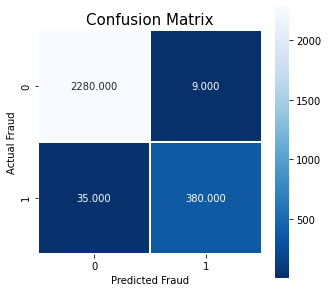

In [33]:
rf_cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sn.heatmap(rf_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Fraud');
plt.xlabel('Predicted Fraud');
all_sample_title = 'Confusion Matrix'
plt.title(all_sample_title, size = 15);

## Gradient Boost
The next model being explored is the Gradient Boost model, which builds an additive model in a forward stage-wise fashion allowing for the optimization of arbitrary differentiable loss functions. Again, using the sklearn function to invoke the model.

The flow of code is similar to that of the Decision Tree.

In [34]:
gbt = GradientBoostingClassifier() #Gradient Boosting Classifier object

gbt = gbt.fit(X_train,y_train) #Train by fitting to training set

y_pred = gbt.predict(X_test) #Predict fraud/label/'FLAG' on the test set

In [35]:
gbt_rec = metrics.recall_score(y_test, y_pred)
print("Recall:",gbt_rec)

Recall: 0.9156626506024096


### Tuning the Gradient Boost

In [36]:
tuner('gbt', 5, 50)

(50, 0.8722891566265061, 11)

We did not improve the recall! We will omit the n_estimators parameter for the Gradient Boost Classifier.


Creating a Confusion Matrix and visualizing it to understand the True Negatives,False Negatives, True Positives and False Positives.

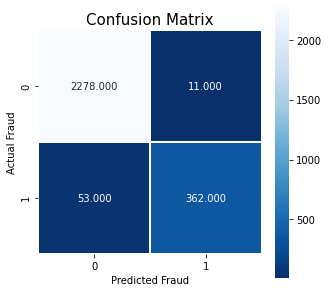

In [37]:
gbt_cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sn.heatmap(gbt_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Fraud');
plt.xlabel('Predicted Fraud');
all_sample_title = 'Confusion Matrix'
plt.title(all_sample_title, size = 15);

## Conclusion

The following are the results from the Classification Models that we have run so far:


In [38]:
data = [["Decision tree", ('%.2f' % (dt_rec*100)), dt_fp],["Logistic Regression", ('%.2f' % (lr_rec*100)), lr_fp],["Random Forest", ('%.2f' % (rf_rec*100)), rf_fp],["Gradient Boost", ('%.2f' % (gbt_rec*100)), gbt_fp]]
resultsDf = pd.DataFrame(data, columns=["Model", "Recall Score", "False Positives"])
resultsDf

,Model,Recall Score,False Positives
0,Decision tree,92.77,65
1,Logistic Regression,0.48,2
2,Random Forest,92.77,9
3,Gradient Boost,87.23,11


If we only look at the Recall score, we may draw the following conclusions:
*   The Decision Tree Model and the Random Forest Model are the best.
*   The Decision Tree and the Random Forest are equally good.




#### On closer Inspection...
we will notice that the False Positives in the case of the Random Forest model is less than 20% of that of the Decision Tree which makes it a superior prediction tool. In a real world scenario, if we wanted to have an intervention of some sort on the cases of predicted fraud, we would prefer to have a lower false positive rate so that we do not intervene in case of genuine transactions.
